In [1]:
!pip install TensorFlow
!pip install matplotlib



# DATA COLLECTION AND PREPROCESSING

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [4]:
 dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plants_Village",
    shuffle=True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)



Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

(32, 256, 256, 3)
[0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1]


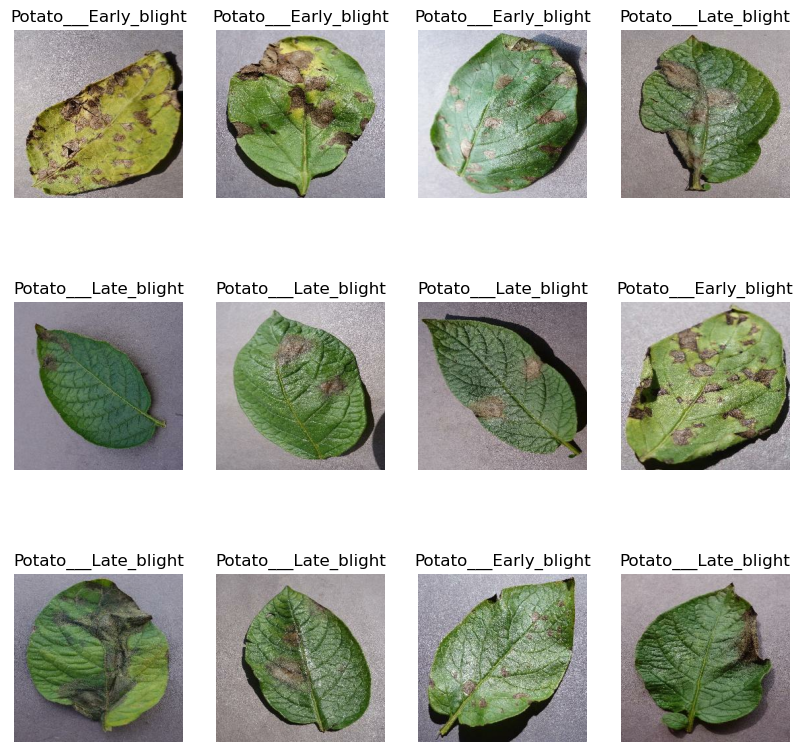

In [7]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
        
    

In [8]:
len(dataset)

68

training_data_percentage = 80  # 80% for training
validation_percentage = 10  # 10% for validation
test_percentage = 10        # 10% for testing

In [9]:
train_size = 0.8
len(dataset)*train_size


54.400000000000006

In [10]:
train_ds= dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split+test_split+val_split) == 1
   
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size) 
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.65882355 0.64705884 0.6901961 ]
  [0.6509804  0.6392157  0.68235296]
  [0.6431373  0.6313726  0.6745098 ]
  ...
  [0.5019608  0.47843137 0.5176471 ]
  [0.48235294 0.45882353 0.49803922]
  [0.5568628  0.53333336 0.57254905]]

 [[0.64705884 0.63529414 0.6784314 ]
  [0.64705884 0.63529414 0.6784314 ]
  [0.64705884 0.63529414 0.6784314 ]
  ...
  [0.5372549  0.5137255  0.5529412 ]
  [0.5058824  0.48235294 0.52156866]
  [0.5137255  0.49019608 0.5294118 ]]

 [[0.6392157  0.627451   0.67058825]
  [0.64705884 0.63529414 0.6784314 ]
  [0.654902   0.6431373  0.6862745 ]
  ...
  [0.57254905 0.54901963 0.5882353 ]
  [0.53333336 0.50980395 0.54901963]
  [0.48235294 0.45882353 0.49803922]]

 ...

 [[0.6156863  0.59607846 0.62352943]
  [0.62352943 0.6039216  0.6313726 ]
  [0.6313726  0.6117647  0.6392157 ]
  ...
  [0.3764706  0.3529412  0.39215687]
  [0.38039216 0.35686275 0.39607844]
  [0.38039216 0.35686275 0.39607844]]

 [[0.6117647  0.5921569  0.61960787]
  [0.62352943 0.6039216  0.6313726 ]


In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# MODEL BUILDING

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation= 'softmax'),
    
])
model.build(input_shape=input_shape)

C:\Users\ansh4\anaconda3\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
) 

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 832ms/step - accuracy: 0.4441 - loss: 0.9375 - val_accuracy: 0.4271 - val_loss: 0.9294
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 728ms/step - accuracy: 0.5446 - loss: 0.8071 - val_accuracy: 0.6562 - val_loss: 0.7834
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 756ms/step - accuracy: 0.8086 - loss: 0.4478 - val_accuracy: 0.8542 - val_loss: 0.3567
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 824ms/step - accuracy: 0.8300 - loss: 0.3961 - val_accuracy: 0.8854 - val_loss: 0.3083
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 762ms/step - accuracy: 0.8681 - loss: 0.3354 - val_accuracy: 0.7656 - val_loss: 0.5699
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 742ms/step - accuracy: 0.8821 - loss: 0.2856 - val_accuracy: 0.8594 - val_loss: 0.3258
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 624ms/step - accuracy: 0.9065 - loss: 0.2495 - val_accuracy: 0.8698 - val_loss: 0.4857
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 708ms/step - accuracy: 0.9158 - loss: 0.2447 - val_accu

In [28]:
len(test_ds)

8

In [29]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.9073 - loss: 0.4329


In [30]:
scores

[0.4577650725841522, 0.90234375]

In [31]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

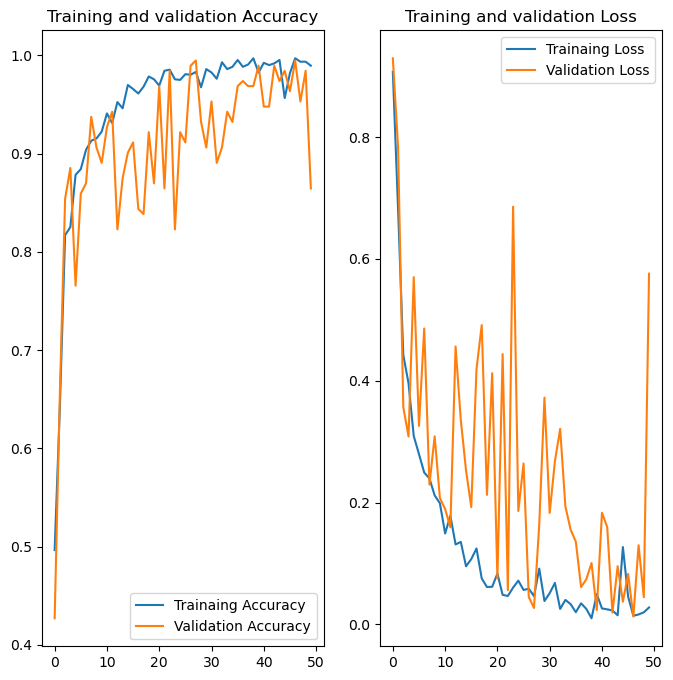

In [33]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Trainaing Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Trainaing Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and validation Loss')
plt.show()


First image to predict
Actual Label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Predicted Label: Potato___Early_blight


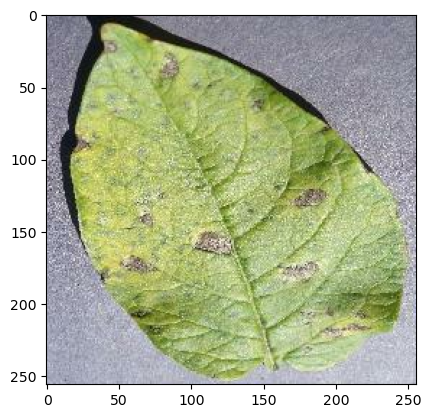

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype("uint8")
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])

    batch_predictions = model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_predictions[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


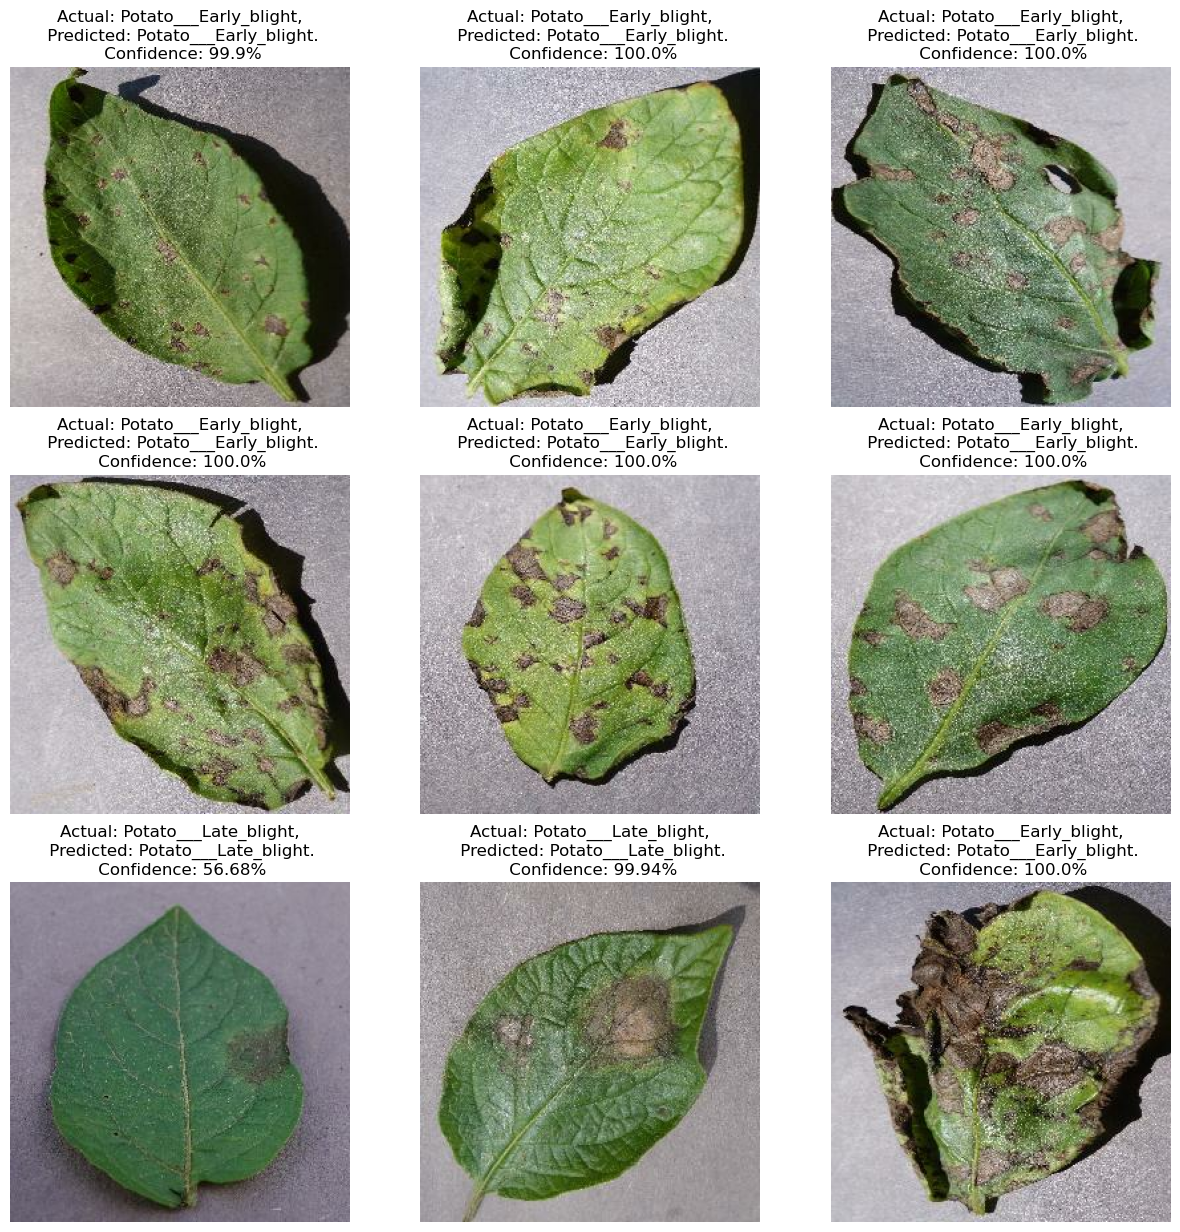

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())

        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [1]:
model_version = 1
model.export(f"../saved_models/{model_version}")

NameError: name 'model' is not defined